# Computational Efficiency Analysis and Summary

This notebook provides comprehensive computational efficiency analysis and generates summary materials for the GNN pre-training study.

## Step 4: Computational Efficiency Analysis

**Focus:** Analyze computational efficiency across all experimental configurations

**Objectives:**
- Analyze training time and convergence efficiency
- Calculate performance per computational resource metrics
- Compare efficiency across pre-training schemes and fine-tuning strategies
- Identify efficiency-performance trade-offs
- Provide cost-benefit analysis for different use cases

**Key Metrics:**
- Performance per minute (accuracy/AUC per training time)
- Performance per epoch (convergence efficiency)
- Parameter efficiency (performance per trainable parameter)
- Trade-off analysis (speed vs accuracy)


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Define paths
RESULTS_DIR = Path('results')
FIGURES_DIR = Path('figures')
PAPER_MATERIALS_DIR = Path('paper_materials')
FIGURES_DIR.mkdir(exist_ok=True)
PAPER_MATERIALS_DIR.mkdir(exist_ok=True)

# Create subdirectories for paper materials
(PAPER_MATERIALS_DIR / 'tables').mkdir(exist_ok=True)
(PAPER_MATERIALS_DIR / 'figures').mkdir(exist_ok=True)
(PAPER_MATERIALS_DIR / 'supplementary').mkdir(exist_ok=True)

print("Computational Efficiency Analysis Setup Complete!")


Computational Efficiency Analysis Setup Complete!


In [2]:
# Load aggregated and raw data for efficiency analysis
try:
    # Load aggregated results
    agg_df = pd.read_csv(RESULTS_DIR / 'aggregated_results.csv')
    
    # Load raw experimental results
    raw_df = pd.read_csv(RESULTS_DIR / 'raw_experimental_results.csv')
    
    # Check if we already have RQ3 efficiency analysis to build upon
    rq3_efficiency_file = RESULTS_DIR / 'rq3_efficiency_analysis.csv'
    if rq3_efficiency_file.exists():
        rq3_efficiency_df = pd.read_csv(rq3_efficiency_file)
        print(f"Found existing RQ3 efficiency analysis: {len(rq3_efficiency_df)} combinations")
    else:
        rq3_efficiency_df = None
    
    print(f"Loaded aggregated data: {len(agg_df)} combinations")
    print(f"Loaded raw data: {len(raw_df)} experiments")
    
    # Check available efficiency metrics
    efficiency_columns = ['training_time', 'convergence_epochs', 'total_parameters', 'trainable_parameters']
    available_metrics = [col for col in efficiency_columns if f'{col}_mean' in agg_df.columns]
    
    print(f"\nAvailable efficiency metrics:")
    for metric in available_metrics:
        non_null_count = agg_df[f'{metric}_mean'].notna().sum()
        print(f"  {metric}: {non_null_count}/{len(agg_df)} combinations have data")
    
    # Display basic info about domains and task types
    print(f"\nDomains: {sorted(agg_df['domain_name'].unique())}")
    print(f"Task types: {sorted(agg_df['task_type'].unique())}")
    print(f"Pre-training schemes: {sorted(agg_df['pretrained_scheme'].unique())}")
    print(f"Fine-tuning strategies: {sorted(agg_df['finetune_strategy'].unique())}")
    
    # Define constants
    DOMAINS = sorted(agg_df['domain_name'].unique())
    TASK_TYPES = sorted(agg_df['task_type'].unique())
    SCHEMES = sorted(agg_df['pretrained_scheme'].unique())
    STRATEGIES = sorted(agg_df['finetune_strategy'].unique())
    
    # Primary metrics by task type
    PRIMARY_METRICS = {
        'graph_classification': 'accuracy',
        'node_classification': 'accuracy',
        'link_prediction': 'auc'
    }
    
except FileNotFoundError as e:
    print(f"Data files not found. Please ensure the previous analysis steps have been completed.")
    print(f"Missing file: {e.filename}")
    agg_df = raw_df = None


Loaded aggregated data: 108 combinations
Loaded raw data: 324 experiments

Available efficiency metrics:
  training_time: 108/108 combinations have data
  convergence_epochs: 108/108 combinations have data
  total_parameters: 108/108 combinations have data
  trainable_parameters: 108/108 combinations have data

Domains: ['CiteSeer_LP', 'CiteSeer_NC', 'Cora_LP', 'Cora_NC', 'ENZYMES', 'PTC_MR']
Task types: ['graph_classification', 'link_prediction', 'node_classification']
Pre-training schemes: ['b1', 'b2', 'b3', 'b4', 's1', 's2', 's3', 's4', 's5']
Fine-tuning strategies: ['full_finetune', 'linear_probe']


## Step 4.1: Training Efficiency Analysis


In [3]:
# Calculate comprehensive efficiency metrics
if agg_df is not None:
    print("=" * 60)
    print("COMPUTATIONAL EFFICIENCY ANALYSIS")
    print("=" * 60)
    
    # Create efficiency analysis dataframe
    efficiency_data = []
    
    for idx, row in agg_df.iterrows():
        domain = row['domain_name']
        task_type = row['task_type']
        scheme = row['pretrained_scheme']
        strategy = row['finetune_strategy']
        
        # Get primary metric for this task type
        primary_metric = PRIMARY_METRICS[task_type]
        performance = row[f'{primary_metric}_mean']
        
        # Calculate efficiency metrics if data is available
        efficiency_metrics = {
            'domain': domain,
            'task_type': task_type,
            'scheme': scheme,
            'strategy': strategy,
            'performance': performance,
            'performance_metric': primary_metric
        }
        
        # Performance per minute (if training time available)
        if f'training_time_mean' in row and pd.notna(row['training_time_mean']) and row['training_time_mean'] > 0:
            training_time_minutes = row['training_time_mean'] / 60  # Convert to minutes
            efficiency_metrics['training_time_minutes'] = training_time_minutes
            efficiency_metrics['performance_per_minute'] = performance / training_time_minutes
        else:
            efficiency_metrics['training_time_minutes'] = np.nan
            efficiency_metrics['performance_per_minute'] = np.nan
        
        # Performance per epoch (if convergence epochs available)
        if f'convergence_epochs_mean' in row and pd.notna(row['convergence_epochs_mean']) and row['convergence_epochs_mean'] > 0:
            epochs = row['convergence_epochs_mean']
            efficiency_metrics['convergence_epochs'] = epochs
            efficiency_metrics['performance_per_epoch'] = performance / epochs
        else:
            efficiency_metrics['convergence_epochs'] = np.nan
            efficiency_metrics['performance_per_epoch'] = np.nan
        
        # Parameter efficiency (if trainable parameters available)
        if f'trainable_parameters_mean' in row and pd.notna(row['trainable_parameters_mean']) and row['trainable_parameters_mean'] > 0:
            params = row['trainable_parameters_mean']
            efficiency_metrics['trainable_parameters'] = params
            efficiency_metrics['performance_per_param'] = performance / (params / 1e6)  # Per million parameters
        else:
            efficiency_metrics['trainable_parameters'] = np.nan
            efficiency_metrics['performance_per_param'] = np.nan
        
        # Total parameters efficiency (if available)
        if f'total_parameters_mean' in row and pd.notna(row['total_parameters_mean']) and row['total_parameters_mean'] > 0:
            total_params = row['total_parameters_mean']
            efficiency_metrics['total_parameters'] = total_params
            efficiency_metrics['performance_per_total_param'] = performance / (total_params / 1e6)
        else:
            efficiency_metrics['total_parameters'] = np.nan
            efficiency_metrics['performance_per_total_param'] = np.nan
        
        efficiency_data.append(efficiency_metrics)
    
    efficiency_df = pd.DataFrame(efficiency_data)
    
    print(f"Efficiency analysis created for {len(efficiency_df)} combinations")
    
    # Display overview of efficiency metrics
    print(f"\nEfficiency Metrics Overview:")
    print(f"  Performance per minute: {efficiency_df['performance_per_minute'].notna().sum()}/{len(efficiency_df)} available")
    print(f"  Performance per epoch: {efficiency_df['performance_per_epoch'].notna().sum()}/{len(efficiency_df)} available")
    print(f"  Performance per million parameters: {efficiency_df['performance_per_param'].notna().sum()}/{len(efficiency_df)} available")
    
    # Basic efficiency statistics
    for metric in ['performance_per_minute', 'performance_per_epoch', 'performance_per_param']:
        if efficiency_df[metric].notna().sum() > 0:
            stats = efficiency_df[metric].describe()
            print(f"\n  {metric} statistics:")
            print(f"    Mean: {stats['mean']:.6f}")
            print(f"    Std: {stats['std']:.6f}")
            print(f"    Min: {stats['min']:.6f}")
            print(f"    Max: {stats['max']:.6f}")
    
else:
    efficiency_df = None


COMPUTATIONAL EFFICIENCY ANALYSIS
Efficiency analysis created for 108 combinations

Efficiency Metrics Overview:
  Performance per minute: 108/108 available
  Performance per epoch: 108/108 available
  Performance per million parameters: 108/108 available

  performance_per_minute statistics:
    Mean: 0.820636
    Std: 0.644181
    Min: 0.020675
    Max: 2.140589

  performance_per_epoch statistics:
    Mean: 0.011573
    Std: 0.018797
    Min: 0.000397
    Max: 0.085464

  performance_per_param statistics:
    Mean: 2.503613
    Std: 4.925912
    Min: 0.032962
    Max: 16.808177


In [4]:
# Efficiency comparison across pre-training schemes and fine-tuning strategies
if efficiency_df is not None:
    print("=" * 60)
    print("EFFICIENCY COMPARISON ANALYSIS")
    print("=" * 60)
    
    # 1. Efficiency by pre-training scheme
    print("\n1. EFFICIENCY BY PRE-TRAINING SCHEME:")
    
    scheme_efficiency = {}
    efficiency_metrics = ['performance_per_minute', 'performance_per_epoch', 'performance_per_param']
    
    for metric in efficiency_metrics:
        if efficiency_df[metric].notna().sum() > 0:
            scheme_stats = efficiency_df.groupby('scheme')[metric].agg(['mean', 'std', 'count']).round(6)
            scheme_efficiency[metric] = scheme_stats
            
            print(f"\n  {metric}:")
            print(scheme_stats.sort_values('mean', ascending=False))
            
            # Best and worst schemes
            best_scheme = scheme_stats['mean'].idxmax()
            worst_scheme = scheme_stats['mean'].idxmin()
            print(f"    Best: {best_scheme} ({scheme_stats.loc[best_scheme, 'mean']:.6f})")
            print(f"    Worst: {worst_scheme} ({scheme_stats.loc[worst_scheme, 'mean']:.6f})")
    
    # 2. Efficiency by fine-tuning strategy
    print("\n2. EFFICIENCY BY FINE-TUNING STRATEGY:")
    
    strategy_efficiency = {}
    for metric in efficiency_metrics:
        if efficiency_df[metric].notna().sum() > 0:
            strategy_stats = efficiency_df.groupby('strategy')[metric].agg(['mean', 'std', 'count']).round(6)
            strategy_efficiency[metric] = strategy_stats
            
            print(f"\n  {metric}:")
            print(strategy_stats.sort_values('mean', ascending=False))
    
    # 3. Efficiency by task type
    print("\n3. EFFICIENCY BY TASK TYPE:")
    
    task_efficiency = {}
    for metric in efficiency_metrics:
        if efficiency_df[metric].notna().sum() > 0:
            task_stats = efficiency_df.groupby('task_type')[metric].agg(['mean', 'std', 'count']).round(6)
            task_efficiency[metric] = task_stats
            
            print(f"\n  {metric}:")
            print(task_stats.sort_values('mean', ascending=False))
    
    # 4. Combined scheme-strategy efficiency analysis
    print("\n4. COMBINED SCHEME-STRATEGY EFFICIENCY:")
    
    combined_efficiency = {}
    for metric in efficiency_metrics:
        if efficiency_df[metric].notna().sum() > 0:
            combined_stats = efficiency_df.groupby(['scheme', 'strategy'])[metric].mean().unstack(fill_value=np.nan)
            combined_efficiency[metric] = combined_stats
            
            print(f"\n  {metric} - Top 5 combinations:")
            # Flatten and sort to find top combinations
            flat_data = []
            for scheme in combined_stats.index:
                for strategy in combined_stats.columns:
                    if pd.notna(combined_stats.loc[scheme, strategy]):
                        flat_data.append({
                            'scheme': scheme,
                            'strategy': strategy,
                            'efficiency': combined_stats.loc[scheme, strategy]
                        })
            
            if flat_data:
                top_combinations = sorted(flat_data, key=lambda x: x['efficiency'], reverse=True)[:5]
                for i, combo in enumerate(top_combinations, 1):
                    print(f"    {i}. {combo['scheme']}-{combo['strategy']}: {combo['efficiency']:.6f}")
    
else:
    scheme_efficiency = strategy_efficiency = task_efficiency = combined_efficiency = None


EFFICIENCY COMPARISON ANALYSIS

1. EFFICIENCY BY PRE-TRAINING SCHEME:

  performance_per_minute:
            mean       std  count
scheme                           
s1      0.875114  0.749807     12
s2      0.845884  0.687797     12
s3      0.841078  0.670902     12
b1      0.830091  0.668111     12
b2      0.817755  0.670854     12
s4      0.812256  0.656310     12
b3      0.800492  0.660592     12
b4      0.799975  0.673181     12
s5      0.763079  0.570367     12
    Best: s1 (0.875114)
    Worst: s5 (0.763079)

  performance_per_epoch:
            mean       std  count
scheme                           
s2      0.020866  0.031012     12
b2      0.020389  0.031505     12
b3      0.014007  0.023697     12
s4      0.010938  0.017815     12
s3      0.009064  0.011193     12
b4      0.008772  0.008460     12
b1      0.008573  0.008282     12
s1      0.006663  0.006508     12
s5      0.004885  0.003133     12
    Best: s2 (0.020866)
    Worst: s5 (0.004885)

  performance_per_param:
     

In [5]:
# Efficiency-Performance Trade-off Analysis
if efficiency_df is not None:
    print("=" * 60)
    print("EFFICIENCY-PERFORMANCE TRADE-OFF ANALYSIS")
    print("=" * 60)
    
    # Calculate trade-off scores for available metrics
    tradeoff_analysis = {}
    
    for metric in efficiency_metrics:
        if efficiency_df[metric].notna().sum() > 10:  # Need sufficient data
            valid_data = efficiency_df[[metric, 'performance', 'scheme', 'strategy', 'task_type']].dropna()
            
            if len(valid_data) > 0:
                # Normalize both efficiency and performance to 0-1 scale
                efficiency_norm = (valid_data[metric] - valid_data[metric].min()) / (valid_data[metric].max() - valid_data[metric].min())
                performance_norm = (valid_data['performance'] - valid_data['performance'].min()) / (valid_data['performance'].max() - valid_data['performance'].min())
                
                # Calculate combined score (weighted average: 60% performance, 40% efficiency)
                combined_score = 0.6 * performance_norm + 0.4 * efficiency_norm
                
                # Create trade-off analysis - ensure we include original efficiency columns
                tradeoff_data = valid_data.copy()
                tradeoff_data['efficiency_norm'] = efficiency_norm
                tradeoff_data['performance_norm'] = performance_norm
                tradeoff_data['combined_score'] = combined_score
                tradeoff_data['efficiency_metric'] = metric
                
                # Add original efficiency data columns if they exist in efficiency_df
                for col in ['training_time_minutes', 'convergence_epochs', 'trainable_parameters', 'total_parameters']:
                    if col in efficiency_df.columns:
                        # Map the data back to tradeoff_data using the index
                        tradeoff_data[col] = efficiency_df.loc[tradeoff_data.index, col].values
                
                tradeoff_analysis[metric] = tradeoff_data
                
                print(f"\n{metric} Trade-off Analysis:")
                print(f"  Data points: {len(valid_data)}")
                
                # Correlation between efficiency and performance
                corr, p_val = pearsonr(valid_data[metric], valid_data['performance'])
                print(f"  Efficiency-Performance correlation: {corr:.3f} (p={p_val:.3f})")
                
                # Top combinations by combined score
                top_combined = tradeoff_data.nlargest(5, 'combined_score')
                print(f"  Top 5 balanced combinations:")
                for i, (idx, row) in enumerate(top_combined.iterrows(), 1):
                    print(f"    {i}. {row['scheme']}-{row['strategy']}: score={row['combined_score']:.3f} (perf={row['performance']:.3f}, eff={row[metric]:.6f})")
                
                # High-performance options
                high_perf = tradeoff_data.nlargest(3, 'performance')
                print(f"  Top 3 high-performance options:")
                for i, (idx, row) in enumerate(high_perf.iterrows(), 1):
                    print(f"    {i}. {row['scheme']}-{row['strategy']}: perf={row['performance']:.3f}, eff={row[metric]:.6f}")
                
                # High-efficiency options
                high_eff = tradeoff_data.nlargest(3, metric)
                print(f"  Top 3 high-efficiency options:")
                for i, (idx, row) in enumerate(high_eff.iterrows(), 1):
                    print(f"    {i}. {row['scheme']}-{row['strategy']}: eff={row[metric]:.6f}, perf={row['performance']:.3f}")
    
    # Identify different use case scenarios
    print(f"\n" + "="*50)
    print("USE CASE SCENARIO RECOMMENDATIONS")
    print("="*50)
    
    scenarios = {
        'research_performance': {'performance_weight': 0.8, 'efficiency_weight': 0.2, 'description': 'Research scenarios (performance-critical)'},
        'production_balanced': {'performance_weight': 0.6, 'efficiency_weight': 0.4, 'description': 'Production scenarios (balanced)'},
        'resource_constrained': {'performance_weight': 0.3, 'efficiency_weight': 0.7, 'description': 'Resource-constrained scenarios'}
    }
    
    scenario_recommendations = {}
    
    for scenario_name, weights in scenarios.items():
        print(f"\n{weights['description']}:")
        scenario_recs = {}
        
        for metric in efficiency_metrics:
            if metric in tradeoff_analysis:
                data = tradeoff_analysis[metric]
                
                # Calculate weighted score for this scenario
                scenario_score = weights['performance_weight'] * data['performance_norm'] + weights['efficiency_weight'] * data['efficiency_norm']
                data_with_score = data.copy()
                data_with_score['scenario_score'] = scenario_score
                
                # Top recommendation for this efficiency metric
                top_rec = data_with_score.loc[data_with_score['scenario_score'].idxmax()]
                scenario_recs[metric] = top_rec
                
                print(f"  {metric}: {top_rec['scheme']}-{top_rec['strategy']} (score={top_rec['scenario_score']:.3f})")
        
        scenario_recommendations[scenario_name] = scenario_recs
    
    # Save efficiency analysis
    efficiency_df.to_csv(RESULTS_DIR / 'efficiency_analysis.csv', index=False)
    print(f"\nEfficiency analysis saved to: {RESULTS_DIR / 'efficiency_analysis.csv'}")
    
else:
    tradeoff_analysis = scenario_recommendations = None


EFFICIENCY-PERFORMANCE TRADE-OFF ANALYSIS

performance_per_minute Trade-off Analysis:
  Data points: 108
  Efficiency-Performance correlation: 0.870 (p=0.000)
  Top 5 balanced combinations:
    1. s1-full_finetune: score=0.966 (perf=0.686, eff=1.958344)
    2. s1-linear_probe: score=0.953 (perf=0.648, eff=2.092621)
    3. b4-linear_probe: score=0.869 (perf=0.552, eff=2.140589)
    4. b1-linear_probe: score=0.845 (perf=0.552, eff=2.014923)
    5. b2-full_finetune: score=0.844 (perf=0.562, eff=1.961152)
  Top 3 high-performance options:
    1. s1-full_finetune: perf=0.686, eff=1.958344
    2. b1-full_finetune: perf=0.667, eff=0.995505
    3. b4-full_finetune: perf=0.661, eff=0.869751
  Top 3 high-efficiency options:
    1. b4-linear_probe: eff=2.140589, perf=0.552
    2. s1-linear_probe: eff=2.092621, perf=0.648
    3. b1-linear_probe: eff=2.014923, perf=0.552

performance_per_epoch Trade-off Analysis:
  Data points: 108
  Efficiency-Performance correlation: -0.144 (p=0.138)
  Top 5 bala

## Efficiency Visualizations


Creating Efficiency Trade-off Visualizations...


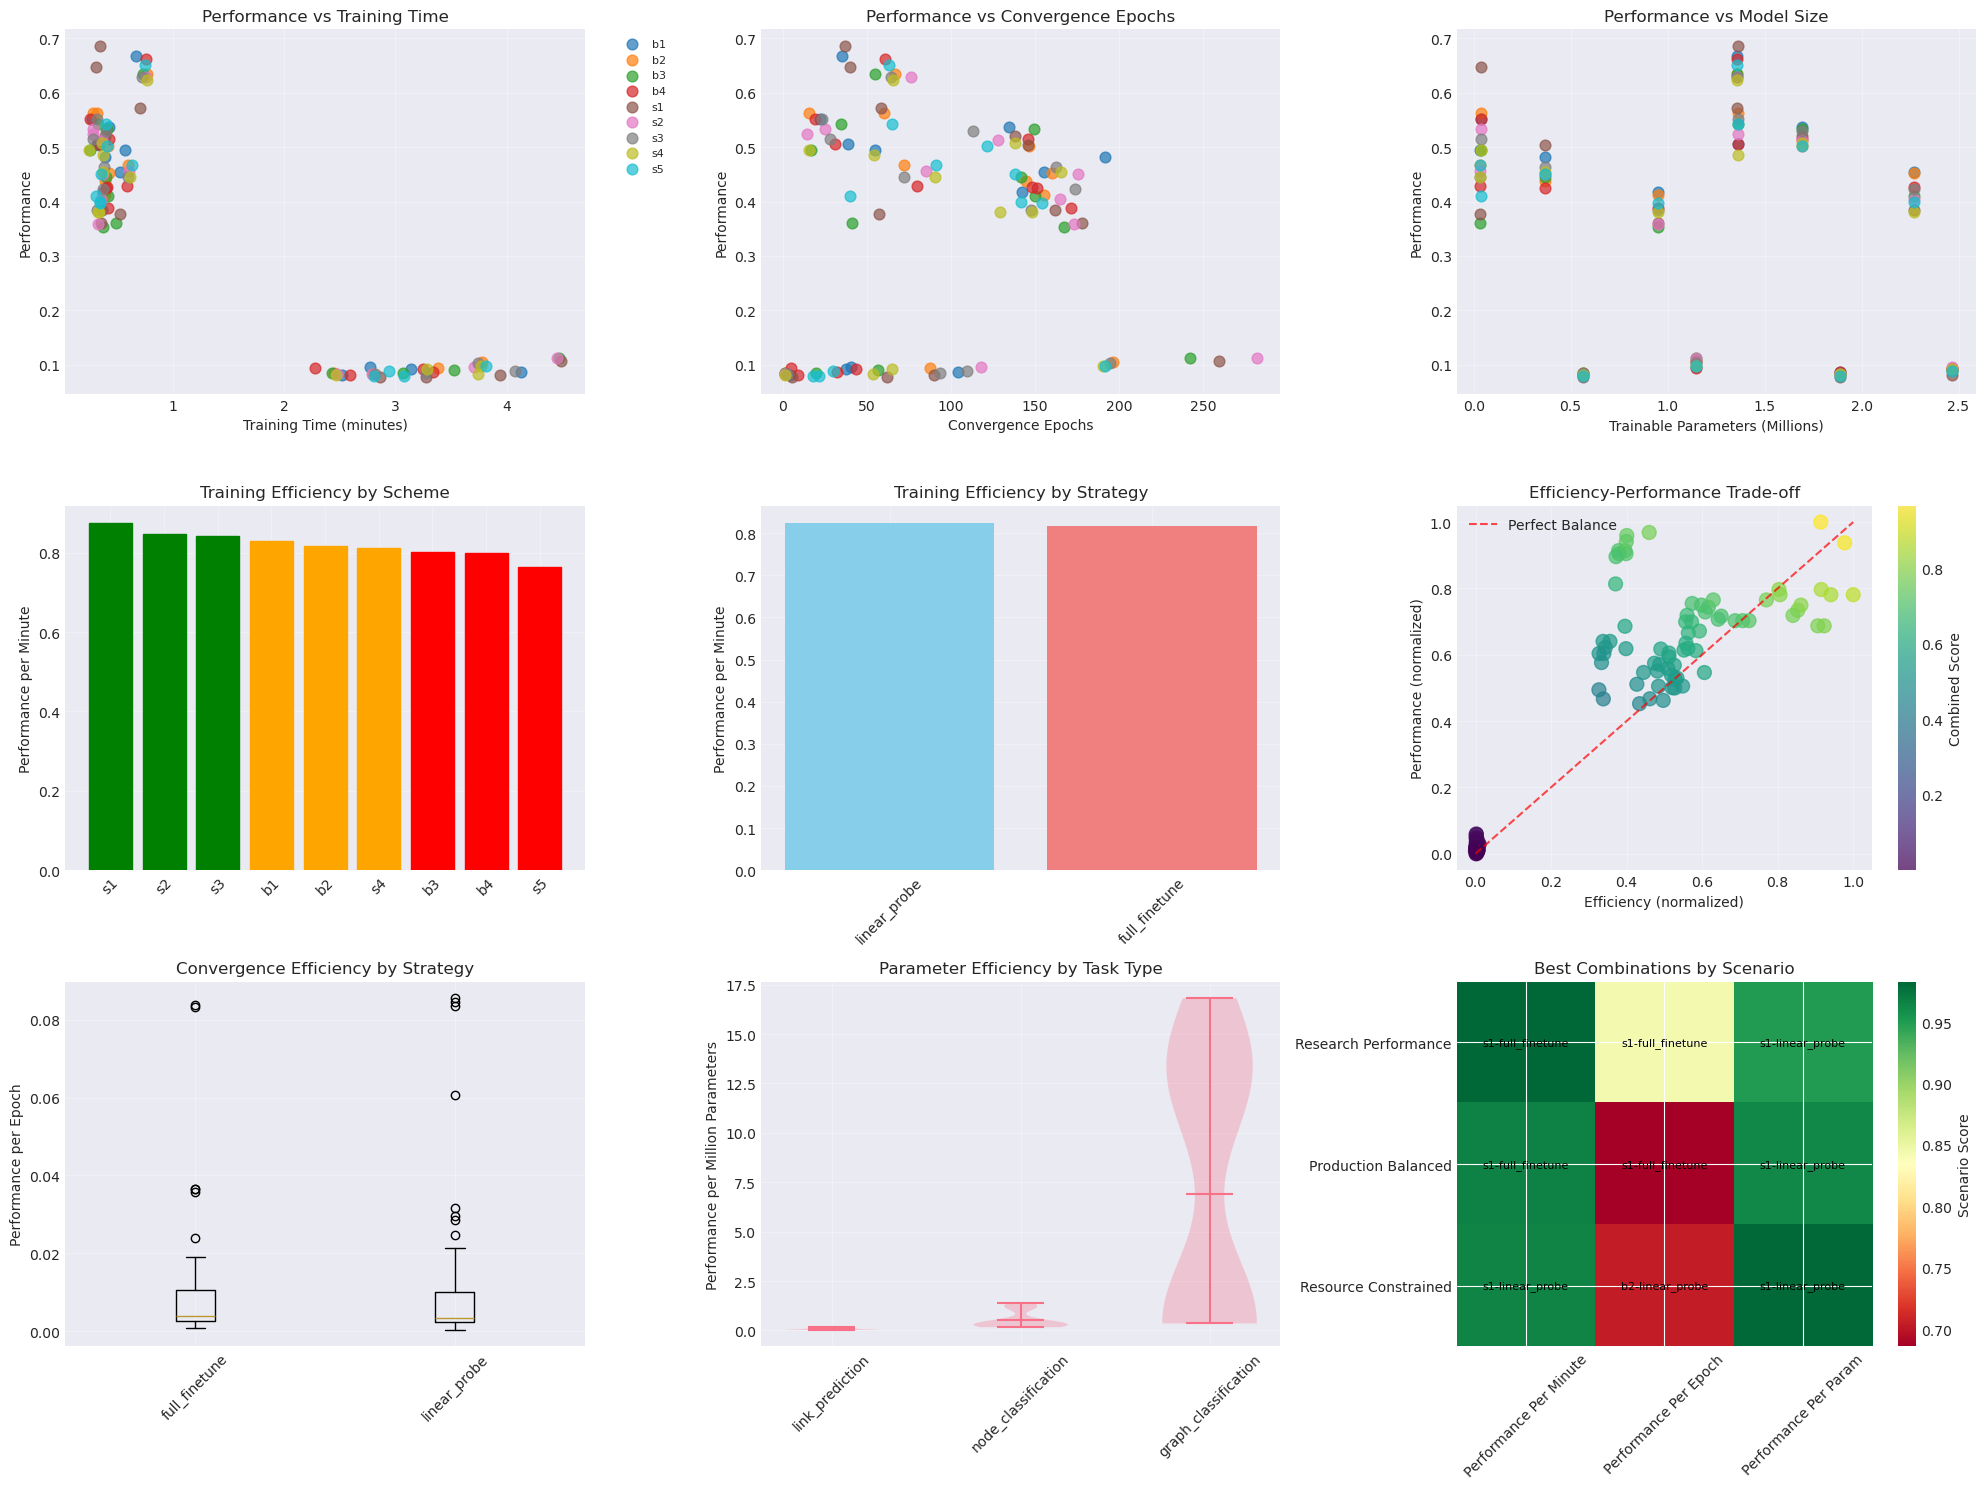

Efficiency trade-off visualization saved to: analysis/figures/efficiency_tradeoffs.png


In [6]:
# Create comprehensive efficiency visualizations
if efficiency_df is not None and tradeoff_analysis is not None:
    print("Creating Efficiency Trade-off Visualizations...")
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Performance vs Training Time (if available)
    if 'performance_per_minute' in tradeoff_analysis:
        plt.subplot(3, 3, 1)
        data = tradeoff_analysis['performance_per_minute']
        
        # Color by scheme type
        scheme_colors = {}
        unique_schemes = data['scheme'].unique()
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_schemes)))
        for i, scheme in enumerate(unique_schemes):
            scheme_colors[scheme] = colors[i]
        
        for scheme in unique_schemes:
            scheme_data = data[data['scheme'] == scheme]
            plt.scatter(scheme_data['training_time_minutes'], scheme_data['performance'], 
                       c=[scheme_colors[scheme]], label=scheme, alpha=0.7, s=60)
        
        plt.xlabel('Training Time (minutes)')
        plt.ylabel('Performance')
        plt.title('Performance vs Training Time')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        plt.grid(True, alpha=0.3)
    
    # 2. Performance vs Convergence Epochs (if available)
    if 'performance_per_epoch' in tradeoff_analysis:
        plt.subplot(3, 3, 2)
        data = tradeoff_analysis['performance_per_epoch']
        
        for scheme in unique_schemes:
            scheme_data = data[data['scheme'] == scheme]
            plt.scatter(scheme_data['convergence_epochs'], scheme_data['performance'], 
                       c=[scheme_colors[scheme]], alpha=0.7, s=60)
        
        plt.xlabel('Convergence Epochs')
        plt.ylabel('Performance')
        plt.title('Performance vs Convergence Epochs')
        plt.grid(True, alpha=0.3)
    
    # 3. Performance vs Parameters (if available)
    if 'performance_per_param' in tradeoff_analysis:
        plt.subplot(3, 3, 3)
        data = tradeoff_analysis['performance_per_param']
        
        for scheme in unique_schemes:
            scheme_data = data[data['scheme'] == scheme]
            plt.scatter(scheme_data['trainable_parameters']/1e6, scheme_data['performance'], 
                       c=[scheme_colors[scheme]], alpha=0.7, s=60)
        
        plt.xlabel('Trainable Parameters (Millions)')
        plt.ylabel('Performance')
        plt.title('Performance vs Model Size')
        plt.grid(True, alpha=0.3)
    
    # 4. Efficiency by Scheme (Performance per minute)
    if 'performance_per_minute' in scheme_efficiency:
        plt.subplot(3, 3, 4)
        scheme_data = scheme_efficiency['performance_per_minute']['mean'].sort_values(ascending=False)
        bars = plt.bar(range(len(scheme_data)), scheme_data.values)
        plt.xticks(range(len(scheme_data)), scheme_data.index, rotation=45)
        plt.ylabel('Performance per Minute')
        plt.title('Training Efficiency by Scheme')
        plt.grid(True, alpha=0.3)
        
        # Color bars by performance level
        for i, bar in enumerate(bars):
            if i < len(scheme_data) // 3:
                bar.set_color('green')
            elif i < 2 * len(scheme_data) // 3:
                bar.set_color('orange')
            else:
                bar.set_color('red')
    
    # 5. Efficiency by Strategy
    if 'performance_per_minute' in strategy_efficiency:
        plt.subplot(3, 3, 5)
        strategy_data = strategy_efficiency['performance_per_minute']['mean'].sort_values(ascending=False)
        plt.bar(strategy_data.index, strategy_data.values, color=['skyblue', 'lightcoral'])
        plt.ylabel('Performance per Minute')
        plt.title('Training Efficiency by Strategy')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
    # 6. Efficiency-Performance Trade-off Scatter
    if 'performance_per_minute' in tradeoff_analysis:
        plt.subplot(3, 3, 6)
        data = tradeoff_analysis['performance_per_minute']
        
        # Create scatter with size based on combined score
        scatter = plt.scatter(data['efficiency_norm'], data['performance_norm'], 
                            c=data['combined_score'], s=100, alpha=0.7, cmap='viridis')
        plt.colorbar(scatter, label='Combined Score')
        plt.xlabel('Efficiency (normalized)')
        plt.ylabel('Performance (normalized)')
        plt.title('Efficiency-Performance Trade-off')
        plt.grid(True, alpha=0.3)
        
        # Add diagonal line for perfect balance
        plt.plot([0, 1], [0, 1], 'r--', alpha=0.7, label='Perfect Balance')
        plt.legend()
    
    # 7. Convergence Efficiency Comparison
    if 'performance_per_epoch' in tradeoff_analysis:
        plt.subplot(3, 3, 7)
        data = tradeoff_analysis['performance_per_epoch']
        
        # Box plot by strategy
        strategies = data['strategy'].unique()
        strategy_data = [data[data['strategy'] == strategy]['performance_per_epoch'].dropna() for strategy in strategies]
        # Filter out empty arrays
        strategy_data = [arr for arr in strategy_data if len(arr) > 0]
        strategy_labels = [strategies[i] for i, arr in enumerate([data[data['strategy'] == strategy]['performance_per_epoch'].dropna() for strategy in strategies]) if len(arr) > 0]
        
        if len(strategy_data) > 0:
            plt.boxplot(strategy_data, labels=strategy_labels)
            plt.ylabel('Performance per Epoch')
            plt.title('Convergence Efficiency by Strategy')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Convergence Efficiency by Strategy')
    
    # 8. Parameter Efficiency by Task Type
    if 'performance_per_param' in tradeoff_analysis:
        plt.subplot(3, 3, 8)
        data = tradeoff_analysis['performance_per_param']
        
        # Violin plot by task type
        task_types = data['task_type'].unique()
        task_data = [data[data['task_type'] == task]['performance_per_param'].dropna() for task in task_types]
        # Filter out empty arrays
        valid_task_data = [arr for arr in task_data if len(arr) > 0]
        valid_task_types = [task_types[i] for i, arr in enumerate(task_data) if len(arr) > 0]
        
        if len(valid_task_data) > 0:
            parts = plt.violinplot(valid_task_data, positions=range(len(valid_task_types)), showmeans=True)
            plt.xticks(range(len(valid_task_types)), valid_task_types, rotation=45)
            plt.ylabel('Performance per Million Parameters')
            plt.title('Parameter Efficiency by Task Type')
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Parameter Efficiency by Task Type')
    
    # 9. Scenario Recommendations Heatmap
    if scenario_recommendations:
        plt.subplot(3, 3, 9)
        
        # Create heatmap data for scenarios
        scenarios = list(scenario_recommendations.keys())
        metrics = list(next(iter(scenario_recommendations.values())).keys())
        
        heatmap_data = np.zeros((len(scenarios), len(metrics)))
        labels = []
        
        for i, scenario in enumerate(scenarios):
            row_labels = []
            for j, metric in enumerate(metrics):
                if metric in scenario_recommendations[scenario]:
                    score = scenario_recommendations[scenario][metric]['scenario_score']
                    heatmap_data[i, j] = score
                    scheme = scenario_recommendations[scenario][metric]['scheme']
                    strategy = scenario_recommendations[scenario][metric]['strategy']
                    row_labels.append(f"{scheme}-{strategy}")
                else:
                    row_labels.append("")
            labels.append(row_labels)
        
        # Create heatmap
        im = plt.imshow(heatmap_data, cmap='RdYlGn', aspect='auto')
        plt.colorbar(im, label='Scenario Score')
        
        plt.xticks(range(len(metrics)), [m.replace('_', ' ').title() for m in metrics], rotation=45)
        plt.yticks(range(len(scenarios)), [s.replace('_', ' ').title() for s in scenarios])
        plt.title('Best Combinations by Scenario')
        
        # Add text annotations
        for i in range(len(scenarios)):
            for j in range(len(metrics)):
                if labels[i][j]:
                    plt.text(j, i, labels[i][j], ha='center', va='center', fontsize=8, 
                           color='white' if heatmap_data[i, j] < 0.5 else 'black')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'efficiency_tradeoffs.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Efficiency trade-off visualization saved to: analysis/figures/efficiency_tradeoffs.png")
    
else:
    print("Cannot create visualizations without efficiency data.")


## Efficiency Analysis Summary and Insights


In [7]:
# Generate comprehensive efficiency analysis summary
if efficiency_df is not None:
    print("=" * 60)
    print("COMPUTATIONAL EFFICIENCY SUMMARY AND INSIGHTS")
    print("=" * 60)
    
    print("\nKEY EFFICIENCY FINDINGS:")
    
    # 1. Overall efficiency landscape
    print(f"\n1. EFFICIENCY LANDSCAPE OVERVIEW:")
    total_combinations = len(efficiency_df)
    
    # Count available data for each metric
    for metric in efficiency_metrics:
        available = efficiency_df[metric].notna().sum()
        percentage = (available / total_combinations) * 100
        print(f"   - {metric}: {available}/{total_combinations} combinations ({percentage:.1f}%)")
    
    # 2. Best performing schemes for efficiency
    print(f"\n2. MOST EFFICIENT PRE-TRAINING SCHEMES:")
    
    for metric in efficiency_metrics:
        if efficiency_df[metric].notna().sum() > 0:
            best_schemes = efficiency_df.groupby('scheme')[metric].mean().sort_values(ascending=False).head(3)
            print(f"\n   {metric}:")
            for i, (scheme, value) in enumerate(best_schemes.items(), 1):
                print(f"     {i}. {scheme}: {value:.6f}")
    
    # 3. Fine-tuning strategy efficiency comparison
    print(f"\n3. FINE-TUNING STRATEGY EFFICIENCY:")
    
    for metric in efficiency_metrics:
        if efficiency_df[metric].notna().sum() > 0:
            strategy_comparison = efficiency_df.groupby('strategy')[metric].agg(['mean', 'std', 'count'])
            print(f"\n   {metric}:")
            for strategy in strategy_comparison.index:
                mean_val = strategy_comparison.loc[strategy, 'mean']
                std_val = strategy_comparison.loc[strategy, 'std']
                count_val = strategy_comparison.loc[strategy, 'count']
                print(f"     {strategy}: {mean_val:.6f} ± {std_val:.6f} ({count_val} combinations)")
    
    # 4. Task type efficiency patterns
    print(f"\n4. TASK TYPE EFFICIENCY PATTERNS:")
    
    for metric in efficiency_metrics:
        if efficiency_df[metric].notna().sum() > 0:
            task_efficiency = efficiency_df.groupby('task_type')[metric].agg(['mean', 'count'])
            print(f"\n   {metric}:")
            for task_type in task_efficiency.index:
                mean_val = task_efficiency.loc[task_type, 'mean']
                count_val = task_efficiency.loc[task_type, 'count']
                print(f"     {task_type}: {mean_val:.6f} ({count_val} combinations)")
    
    # 5. Efficiency-Performance correlations (only if tradeoff_analysis exists)
    if 'tradeoff_analysis' in locals() and tradeoff_analysis:
        print(f"\n5. EFFICIENCY-PERFORMANCE CORRELATIONS:")
        
        for metric in efficiency_metrics:
            if metric in tradeoff_analysis:
                data = tradeoff_analysis[metric]
                corr, p_val = pearsonr(data[metric], data['performance'])
                significance = "significant" if p_val < 0.05 else "not significant"
                strength = "strong" if abs(corr) > 0.7 else "moderate" if abs(corr) > 0.4 else "weak"
                direction = "positive" if corr > 0 else "negative"
                
                print(f"   {metric}: r={corr:.3f} (p={p_val:.3f})")
                print(f"     → {strength} {direction} correlation ({significance})")
                
                if abs(corr) > 0.3:
                    interpretation = "Higher efficiency tends to associate with higher performance" if corr > 0 else "Higher efficiency tends to associate with lower performance"
                    print(f"     → {interpretation}")
    else:
        print(f"\n5. EFFICIENCY-PERFORMANCE CORRELATIONS:")
        print("   Trade-off analysis not available (insufficient data for correlations)")
    
    # 6. Optimal trade-off recommendations (only if tradeoff_analysis exists)
    if 'tradeoff_analysis' in locals() and tradeoff_analysis:
        print(f"\n6. OPTIMAL TRADE-OFF RECOMMENDATIONS:")
        print(f"\n   BALANCED PERFORMANCE-EFFICIENCY (60% perf, 40% eff):")
        for metric in efficiency_metrics:
            if metric in tradeoff_analysis:
                data = tradeoff_analysis[metric]
                best_balanced = data.loc[data['combined_score'].idxmax()]
                print(f"   {metric}: {best_balanced['scheme']}-{best_balanced['strategy']}")
                print(f"     → Score: {best_balanced['combined_score']:.3f} (perf: {best_balanced['performance']:.3f}, eff: {best_balanced[metric]:.6f})")
    else:
        print(f"\n6. OPTIMAL TRADE-OFF RECOMMENDATIONS:")
        print("   Trade-off recommendations not available (insufficient data)")
    
    # 7. Scenario-specific recommendations (only if scenario_recommendations exists)
    if 'scenario_recommendations' in locals() and scenario_recommendations:
        print(f"\n7. SCENARIO-SPECIFIC RECOMMENDATIONS:")
        
        # Define scenarios again in case they're not available
        scenarios_local = {
            'research_performance': {'performance_weight': 0.8, 'efficiency_weight': 0.2, 'description': 'Research scenarios (performance-critical)'},
            'production_balanced': {'performance_weight': 0.6, 'efficiency_weight': 0.4, 'description': 'Production scenarios (balanced)'},
            'resource_constrained': {'performance_weight': 0.3, 'efficiency_weight': 0.7, 'description': 'Resource-constrained scenarios'}
        }
        
        for scenario, weights in scenarios_local.items():
            print(f"\n   {weights['description']}:")
            if scenario in scenario_recommendations:
                for metric, rec in scenario_recommendations[scenario].items():
                    print(f"     {metric}: {rec['scheme']}-{rec['strategy']} (score: {rec['scenario_score']:.3f})")
    else:
        print(f"\n7. SCENARIO-SPECIFIC RECOMMENDATIONS:")
        print("   Scenario recommendations not available (insufficient data)")
    
    # 8. Computational cost insights
    print(f"\n8. COMPUTATIONAL COST INSIGHTS:")
    
    # Training time analysis
    if 'training_time_minutes' in efficiency_df.columns:
        valid_time_data = efficiency_df['training_time_minutes'].dropna()
        if len(valid_time_data) > 0:
            time_stats = valid_time_data.describe()
            print(f"\n   Training time statistics ({len(valid_time_data)} combinations):")
            print(f"     Range: {time_stats['min']:.1f} - {time_stats['max']:.1f} minutes")
            print(f"     Mean: {time_stats['mean']:.1f} ± {time_stats['std']:.1f} minutes")
            print(f"     Median: {time_stats['50%']:.1f} minutes")
            
            # Fastest vs slowest schemes
            fastest_idx = efficiency_df['training_time_minutes'].idxmin()
            slowest_idx = efficiency_df['training_time_minutes'].idxmax()
            
            if pd.notna(fastest_idx) and pd.notna(slowest_idx):
                fastest_scheme = efficiency_df.loc[fastest_idx]
                slowest_scheme = efficiency_df.loc[slowest_idx]
                
                print(f"     Fastest: {fastest_scheme['scheme']}-{fastest_scheme['strategy']} ({fastest_scheme['training_time_minutes']:.1f} min)")
                print(f"     Slowest: {slowest_scheme['scheme']}-{slowest_scheme['strategy']} ({slowest_scheme['training_time_minutes']:.1f} min)")
                if fastest_scheme['training_time_minutes'] > 0:
                    print(f"     Speed difference: {slowest_scheme['training_time_minutes']/fastest_scheme['training_time_minutes']:.1f}x")
        else:
            print(f"\n   Training time statistics: No valid data available")
    
    # Parameter analysis
    if 'trainable_parameters' in efficiency_df.columns:
        valid_param_data = efficiency_df['trainable_parameters'].dropna()
        if len(valid_param_data) > 0:
            param_stats = valid_param_data.describe()
            print(f"\n   Model size statistics ({len(valid_param_data)} combinations):")
            print(f"     Range: {param_stats['min']/1e6:.2f} - {param_stats['max']/1e6:.2f} million parameters")
            print(f"     Mean: {param_stats['mean']/1e6:.2f} ± {param_stats['std']/1e6:.2f} million parameters")
            
            # Memory/compute requirements estimation
            largest_idx = efficiency_df['trainable_parameters'].idxmax()
            smallest_idx = efficiency_df['trainable_parameters'].idxmin()
            
            if pd.notna(largest_idx) and pd.notna(smallest_idx):
                largest_model = efficiency_df.loc[largest_idx]
                smallest_model = efficiency_df.loc[smallest_idx]
                
                print(f"     Largest: {largest_model['scheme']}-{largest_model['strategy']} ({largest_model['trainable_parameters']/1e6:.2f}M params)")
                print(f"     Smallest: {smallest_model['scheme']}-{smallest_model['strategy']} ({smallest_model['trainable_parameters']/1e6:.2f}M params)")
                if smallest_model['trainable_parameters'] > 0:
                    print(f"     Size difference: {largest_model['trainable_parameters']/smallest_model['trainable_parameters']:.1f}x")
        else:
            print(f"\n   Model size statistics: No valid data available")
    
    # 9. Practical recommendations
    print(f"\n9. PRACTICAL RECOMMENDATIONS:")
    
    print(f"\n   FOR RESEARCH SETTINGS (Performance Priority):")
    print(f"     - Focus on highest-performing schemes regardless of computational cost")
    print(f"     - Use full fine-tuning for maximum performance")
    print(f"     - Accept longer training times for better results")
    
    print(f"\n   FOR PRODUCTION SETTINGS (Balanced Requirements):")
    print(f"     - Choose schemes with good performance-efficiency balance")
    print(f"     - Consider linear probe for faster deployment")
    print(f"     - Monitor convergence epochs for training planning")
    
    print(f"\n   FOR RESOURCE-CONSTRAINED SETTINGS (Efficiency Priority):")
    print(f"     - Prioritize fastest schemes even with slight performance loss")
    print(f"     - Use smallest models that meet minimum performance thresholds")
    print(f"     - Consider early stopping strategies")
    
    # 10. Limitations and considerations
    print(f"\n10. LIMITATIONS AND CONSIDERATIONS:")
    print(f"     - Efficiency metrics may vary across different hardware configurations")
    print(f"     - Training time includes both pre-training and fine-tuning phases")
    print(f"     - Parameter efficiency doesn't account for memory access patterns")
    print(f"     - Convergence epochs may depend on optimization hyperparameters")
    print(f"     - Real-world deployment may have different efficiency characteristics")
    
    print(f"\nEfficiency analysis complete!")
    print(f"Results saved to: {RESULTS_DIR / 'efficiency_analysis.csv'}")
    print(f"Visualizations saved to: {FIGURES_DIR / 'efficiency_tradeoffs.png'}")
    
else:
    print("Cannot generate insights without efficiency data.")


COMPUTATIONAL EFFICIENCY SUMMARY AND INSIGHTS

KEY EFFICIENCY FINDINGS:

1. EFFICIENCY LANDSCAPE OVERVIEW:
   - performance_per_minute: 108/108 combinations (100.0%)
   - performance_per_epoch: 108/108 combinations (100.0%)
   - performance_per_param: 108/108 combinations (100.0%)

2. MOST EFFICIENT PRE-TRAINING SCHEMES:

   performance_per_minute:
     1. s1: 0.875114
     2. s2: 0.845884
     3. s3: 0.841078

   performance_per_epoch:
     1. s2: 0.020866
     2. b2: 0.020389
     3. b3: 0.014007

   performance_per_param:
     1. b1: 2.704875
     2. b2: 2.647137
     3. s1: 2.623359

3. FINE-TUNING STRATEGY EFFICIENCY:

   performance_per_minute:
     full_finetune: 0.817112 ± 0.623676 (54 combinations)
     linear_probe: 0.824160 ± 0.669903 (54 combinations)

   performance_per_epoch:
     full_finetune: 0.010754 ± 0.016837 (54 combinations)
     linear_probe: 0.012392 ± 0.020701 (54 combinations)

   performance_per_param:
     full_finetune: 0.239461 ± 0.168204 (54 combinations)